In [142]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [143]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

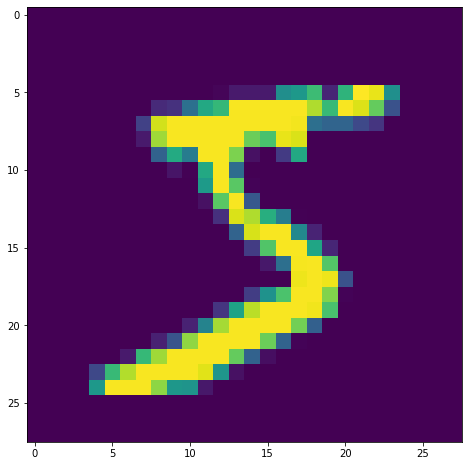

In [144]:
plt.figure()
plt.imshow(x_train[0])
plt.show()

In [145]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [146]:
model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test,  y_test, verbose=2)

Epoch 1/5
60000/60000 [==============================] - 4s 62us/sample - loss: 0.2945 - acc: 0.9147
Epoch 2/5
60000/60000 [==============================] - 3s 56us/sample - loss: 0.1419 - acc: 0.9580
Epoch 3/5
60000/60000 [==============================] - 3s 55us/sample - loss: 0.1080 - acc: 0.9674
Epoch 4/5
60000/60000 [==============================] - 3s 55us/sample - loss: 0.0881 - acc: 0.9730
Epoch 5/5
60000/60000 [==============================] - 3s 56us/sample - loss: 0.0743 - acc: 0.9763
10000/10000 - 1s - loss: 0.0749 - acc: 0.9758


[0.07492752506698017, 0.9758]

In [168]:
test_img = x_train[0]

def get_label_confidence(image, model):
    pr = model.predict(image.reshape(1, 28, 28))
    image_class = model.predict_classes(image.reshape(1, 28, 28))
    return 'Predicted {} : {:.7f}'.format(image_class[0], max(max(pr)))
   
get_label_confidence(test_img, model)

'Predicted 5 : 0.99941'

In [148]:
image_probs = model.predict(test_img.reshape(1, 28, 28))
label = tf.one_hot(5, image_probs.shape[-1])
print(label)

Tensor("one_hot_170:0", shape=(10,), dtype=float32)


In [149]:
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [150]:
model2.fit(x_train, y_train, epochs=5)
model2.evaluate(x_test,  y_test, verbose=2)

Epoch 1/5
60000/60000 [==============================] - 4s 62us/sample - loss: 0.2945 - acc: 0.9142
Epoch 2/5
60000/60000 [==============================] - 3s 56us/sample - loss: 0.1447 - acc: 0.9577
Epoch 3/5
60000/60000 [==============================] - 3s 56us/sample - loss: 0.1092 - acc: 0.9667
Epoch 4/5
60000/60000 [==============================] - 3s 58us/sample - loss: 0.0888 - acc: 0.9732
Epoch 5/5
60000/60000 [==============================] - 4s 59us/sample - loss: 0.0756 - acc: 0.9764
10000/10000 - 1s - loss: 0.0724 - acc: 0.9763


[0.07239134791265242, 0.9763]

In [189]:
sess = K.get_session()
x = x_train[0]
x = np.reshape(x, (1, 28, 28))
x_adv = x
x_noise = np.zeros_like(x)

In [190]:
model1_initial = 'Model 1 - ' + get_label_confidence(x_adv, model)
model2_initial = 'Model 2 - ' + get_label_confidence(x_adv, model2)
print('Initial Results')
print(model1_initial)
print(model2_initial)

Initial Results
Model 1 - Predicted 5 : 0.99941
Model 2 - Predicted 5 : 0.99886


In [194]:
# Set variables
epochs = 21
epsilon = 0.01
true_class = 5
target_class = 2
prev_probs = []

print('Attacked NN Results on FGSM')

for i in range(epochs): 
    # One hot encode the target class
    target = K.one_hot(target_class, 10)
    true = K.one_hot(true_class, 10)
    
    # Get the loss and gradient of the loss wrt the inputs
    loss = -1 * K.categorical_crossentropy(target, model.output) + K.categorical_crossentropy(true, model2.output)
    grads = K.gradients(loss, model.input)

    # Get the sign of the gradient
    #delta = K.sign(grads[0])
    delta = grads[0]
    x_noise = x_noise + delta

    # Perturb the image
    x_adv = x_adv + epsilon*delta

    # Get the new image and predictions
    x_adv = sess.run(x_adv, feed_dict={model.input:x})
    preds = model.predict(x_adv)

    # Store the probability of the target class
    prev_probs.append(preds[0][target_class])

    if i%10 == 0:
        top_pred = get_label_confidence(x_adv, model)
        print('Epoch:', i, '\t', 'Targeted', target_class, ':',
              preds[0][target_class], '\t', top_pred)

Attacked NN Results on FGSM
Epoch: 0 	 Targeted 2 : 3.9431903e-08 	 Predicted 5 : 0.99612
Epoch: 10 	 Targeted 2 : 0.9822525 	 Predicted 2 : 0.98225
Epoch: 20 	 Targeted 2 : 0.99991465 	 Predicted 2 : 0.99991


In [195]:
model1_final = 'Model 1 - ' + get_label_confidence(x_adv, model)
model2_final = 'Model 2 - ' + get_label_confidence(x_adv, model2)
print('Final Results')
print(model1_final)
print(model2_final)

Final Results
Model 1 - Predicted 2 : 0.99991
Model 2 - Predicted 2 : 1.00000


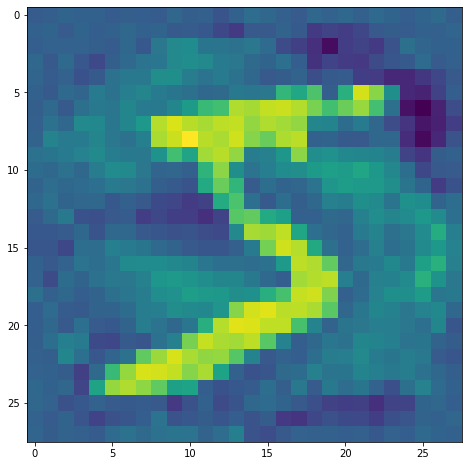

In [196]:
plt.imshow(x_adv[0])
plt.show()

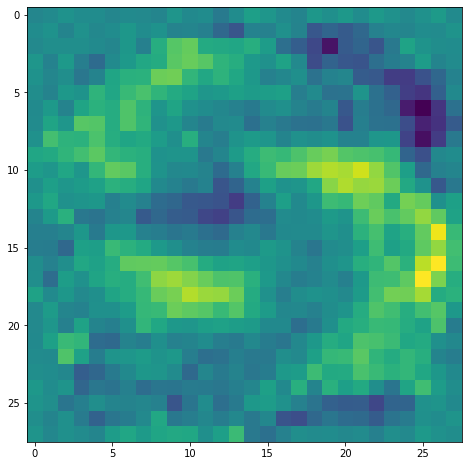

In [197]:
plt.imshow(x_adv[0] - x[0])
plt.show()